In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
import sys
sys.path.append("path_to_project_root")
import pandas as pd

from src.main import RacingMLPipeline

### Run Pipeline End-to-End

#### Adjust Config File (config.yaml)

```yaml
random_seed: 42
data_path: data/cup_race_results_2014_2024.csv
champions_path: data/champions_2014_2024.csv

generate_grouped_data: False

target_variable: wins
predictors:
  force_categorical:
    - race_season
  include: []  # Empty: uses automatic predictor selection
  exclude: # if empty: no manual exclusions (automatic exclusions still apply)
    - avg_diff_time_sec
    - avg_diff_time_min
    - total_laps
    - avg_starting_position
    - top_5
    - top_10
    - total_laps_led  
    - num_races

train_test_split:
  test_size: 0.3
  stratify: race_season  # Stratifies by race_season - ensures relatively similar distribution among train & test

cross_validation:
  folds: 5  # Enables 5-fold CV; set to null or omit to disable

models:
  ols: false
  poisson: false
  neg_binomial: false
  zero_inflated_poisson: false
  zero_inflated_neg_binomial: false
  xgboost: true  # Explicitly enable xgboost
  gbm: false      # Explicitly enable gbm

hyperparameters:
  xgboost:
    enabled: true
    search_type: randomized  # Switch to RandomizedSearchCV
    n_iter: 50              # Number of random combinations to try 50 x 5 = 250 fits
    param_grid:
      max_depth: [3, 5, 7]
...

model_selection:
  # manual_model_id: gbm_20250311_2138  # e.g., ols_20240315_143500 if manually selecting else null
  manual_model_id: zip_20250312_1409
  # manual_model_id: null
  metric: test_RMSE
  minimize: true
```

#### Execute ***run_pipeline()*** Method

Running pipeline for model: *zip_20250312_1409*

Model Type: Zero-Inflated Poisson

In [26]:
pipeline = RacingMLPipeline("config.yaml")
pipeline.run_pipeline()

2025-03-12 22:16:38,464 - RacingMLPipeline - INFO - Initialized RacingMLPipeline with config: config.yaml
2025-03-12 22:16:38,464 - RacingMLPipeline - INFO - Starting Racing ML Pipeline...
2025-03-12 22:16:38,504 - RacingMLPipeline - INFO - model_id found in config file
2025-03-12 22:16:38,504 - RacingMLPipeline - INFO - Manual model selection enabled with model_id: poisson_20250312_1409
2025-03-12 22:16:38,518 - RacingMLPipeline - INFO - Loaded model from models\poisson\poisson_20250312_1409\poisson_20250312_1409.pkl
2025-03-12 22:16:38,518 - RacingMLPipeline - INFO - Manual model poisson_20250312_1409 of type poisson loaded successfully.
2025-03-12 22:16:38,518 - RacingMLPipeline - INFO - Loading processed data from data\aggregated_driver_data.csv
2025-03-12 22:16:38,518 - RacingMLPipeline - INFO - Driver-Aggregated Data (first 5 rows):
2025-03-12 22:16:38,518 - RacingMLPipeline - INFO -  race_season  driver_id driver_fullname  num_races  wins  top_5  top_10  finish_2_5  finish_6_10 

File loaded successfully with encoding: utf-8


#### Inspect Leaderboard

In [25]:
pd.read_csv('models/leaderboard.csv')

,model_id,model_type,timestamp,train_RMSE,test_RMSE,train_MAE,test_MAE,train_R2,test_R2,CV_RMSE_Mean,CV_RMSE_Std,train_test_diff
0,gbm_20250312_1325,gbm,20250312_1325,0.233236,0.757774,0.116723,0.372363,0.967888,0.733576,0.736935,0.042956,-0.524538
1,gbm_20250312_1740,gbm,20250312_1740,0.324494,0.774453,0.161079,0.382465,0.937844,0.721719,0.743694,0.042283,-0.449959
2,xgboost_20250312_1740,xgboost,20250312_1740,0.302220,0.781252,0.141786,0.360431,0.946084,0.716811,0.661109,0.051914,-0.479032
3,xgboost_20250312_1325,xgboost,20250312_1325,0.007882,0.797033,0.004325,0.399319,0.999963,0.705255,0.765778,0.075304,-0.789151
4,ols_20250312_1409,ols,20250312_1409,0.621204,0.802620,0.301909,0.400279,0.772208,0.701109,0.693959,0.105832,-0.181416
5,xgboost_20250312_1409,xgboost,20250312_1409,0.045033,0.829678,0.023480,0.410440,0.998803,0.680616,0.691927,0.034260,-0.784645
6,poisson_20250312_1409,poisson,20250312_1409,0.717531,0.891409,0.310055,0.411980,0.696086,0.631322,0.693959,0.105832,-0.173878
7,zip_20250312_1409,zip,20250312_1409,0.675794,1.267273,0.321196,0.500946,0.730413,0.254866,NaN,NaN,-0.591479
8,negbin_20250312_1409,negbin,20250312_1409,1.222357,1.885779,0.380379,0.516440,0.118005,-0.649968,0.693959,0.105832,-0.663422


#### QUESTION #1: PREDICTION MODEL FOR EXPECTED WINS PER SEASON

### MODEL CHOICE

The top model isn't always the best choice. In our scenario, we see a significant amount of over-fitting among the ML models (GBM / XGBoost) as measured by their Train RMSE vs their Test RMSE (or more directly, via the `train_test_diff` column). 

It is worth noting that the XGBoost model run at 20250312_1740 was conducted with a more exhaustive grid search for its hyperparameter optimization, with its objective function changed from `reg:squarederror` to `count:poisson` (i.e. from a squared loss function to a lambda Poisson mean) to better encapsulate the reality of the positive-definite nature of our data and response. By the same token, the eval_metric were changed from`rmse` to `poisson-nloglik` for the same reasons. Because of ML models' flexibility in leveraging various loss functions, there are parameters that were adjusted to account for the non-negative nature of the response.

Given the inherent nature of predicting wins which cannot logically fall below zero, the modeling frameworks needed to be constrained accordingly. For this reason alone, OLS regression is excluded immediately from final consideration. Note that there are remediation measures, such as log-transforming a combination of the response and/or predictors, but due to time constraints, these tests were omitted in lieu of other more distributionally-sound models. The most natural of the group are the Poisson Regression models whose underlying distribution seeks to model exactly what we are trying to measure: # of success per fixed increment of time (or space). In our situation, we want to model how many wins (variable) per season (fixed). 

A Negative Binomial model was also considered for its natural extension from the poisson family of models that describe discrete / count data. Intuitively, a negative binomial distribution would not necessarily characterize the uncertainty appropriately (as it is mainly used in situations where the number of successes are fixed - i.e. # of trials until the nth success: "how many races until Denny Hamlin will score his 3rd win of the season?"). Since we are estimating # of expected wins, I felt that this distribution lends itself fairly closely to this distributional assumption, ceteris parabis. 

The last iteration of models that was performed considered leveraging a zero-inflated model. The underlying assumption of such models is to assume a point-mass at zero and regress everything else to the response accordingly. These are considered "two-component" models that seek to separate out (1) the probability of being in the "structural zero" group (i.e. the group that are inherent to the underlying data - for example, racers who quit halfway through a season will never, ipso facto, get a win in the second half of the season logically speaking), with (2) the probability that the zeroes actually did come from the underlying Poisson distribution (i.e. a racer just had an off-day and lost the lead). There are three main model types in this category of models: Zero-Inflated Poisson (ZIP), Zero-Inflated Negative Binomial (ZINB), and Zero-Inflated Binomial (ZIB). Due to the computational complexity of running these, only the ZIP model was run due to its direct relevance with the response scenario. However, upon evaluation, the ZIP model did not perform as adequately as the normal Poisson model. The ZIP model overfit by a factor of 3.5 to the normal Poisson model (-.59/-.17 train_test_diff).

Therefore, after considering all of the distributional assumptions and performance evaluations, my suggestion is to leverage a **Poisson Regression model (`model_id: poisson_20250312_1409`)** for further analysis. It is statistically robust, does not exhibit overfitting, and exactly characterizes the uncertainty of expected number of wins per season. Occasionally, throughout this notebook, the top GBM model may be referenced for comparison.
___

The ML Pipeline package has the following structure:

Each time the modeling process is executed, a separate folder will be created for that specific model type and model ID (see the Poisson example below), along with subdirectories for plots and analyses. In order to answer the questions surrounding expected wins and who over or under performed, we need to ensure our modeling framework is sound and robust. Therefore, once a model is chosen from the leaderboard, it can be further inspected for various visualizations (PDPs, correlation heatmaps, etc.). All models are saved into these respective folders as `.pkl` files that can easily be loaded with the included functionality of the package.

```
# ===============================
# NASCAR Race Results ML Pipeline
# ===============================
#
# Directory Structure:
# NASCAR_ANALYSIS/
# │
# ├── data/                                                 # Input data files
# │   ├── aggregated_driver_data.csv                        # Grouped source data by driver by year
# │   ├── champions_2014_2024.csv                           # Web-sourced driver data (winning driver by year + associated team)
# │   ├── cup_race_results_2014_2024.csv                    # Source data
# │   └── team_wins_by_year.csv                             # Web-sourced team data (total team wins by year)
# │
# ├── models/                                               # Model outputs (trained models + analysis)
# │   ├── ols/
# │   ├── poisson/
# │   │   └── poisson_20250312_1409/
# │   │       ├── analysis/                                 # Case Study Questions + Answers
# |   |            ├── driver_championship_comparison.csv
# |   |            ├── driver_over_under_performance.csv
# |   |            ├── team_championship_comparison.csv
# |   |            ├── team_over_under_performance.csv
# │   │       ├── plots/                                    # Visualizations
# │   │       ├── poisson_20250312_1409.pkl
# │   │       └── predictor_selection.csv
# │   ├── ...                                               # More model types: gbm, zip, etc. 
# │   ├── leaderboard.csv                                   # Model Leaderboard
# │
# ├── src/                                                  # Source code
# │   ├── championship_evaluator.py
# │   ├── logger_config.py
# │   ├── main.py
# │   ├── utils.py
# │   └── visualization.py
# │
# ├── .gitignore                                            # For GitHub
# ├── config.yaml                                           # User-defined config for modeling execution
# ├── nascar_analysis.ipynb                                 # Jupyter Notebook version for easier workflow
# ├── README.md                                             # Project instructions & documentation
# └── requirements.txt                                      # Package dependencies
```

#### QUESTION #2: DRIVER + TEAM OVER/UNDER PERFORMANCE ACROSS SEASONS

#####################################################################################################
#                                            GBM                                              
#####################################################################################################

+-----------       Aggregated DRIVER Predictions: Expected Wins vs Actual Wins      -----------+


,race_season,driver_fullname,actual_wins,expected_wins,model_type,model_id,win_diff,performance_diff,over_under
0,2024,Kyle Larson,6,5.654080,gbm,gbm_20250312_1740,0.345920,0.345920,Over
1,2024,Joey Logano,4,2.844694,gbm,gbm_20250312_1740,1.155306,1.155306,Over
2,2024,William Byron,3,1.919168,gbm,gbm_20250312_1740,1.080832,1.080832,Over
3,2024,Tyler Reddick,3,2.403658,gbm,gbm_20250312_1740,0.596342,0.596342,Over
4,2024,Ryan Blaney,3,2.559468,gbm,gbm_20250312_1740,0.440532,0.440532,Over


+-----------       Aggregated TEAM Predictions: Expected Wins vs Actual Wins      -----------+


,race_season,team_name,actual_wins,expected_wins,model_type,model_id,win_diff,performance_diff,over_under
0,2024,Hendrick Motorsports,11,9.771909,gbm,gbm_20250312_1740,1.228091,1.228091,Over
1,2024,Team Penske,8,5.666675,gbm,gbm_20250312_1740,2.333325,2.333325,Over
2,2024,Joe Gibbs Racing,6,9.732868,gbm,gbm_20250312_1740,-3.732868,-3.732868,Under
3,2024,23XI Racing,3,2.819658,gbm,gbm_20250312_1740,0.180342,0.180342,Over
4,2024,Trackhouse Racing,2,1.565185,gbm,gbm_20250312_1740,0.434815,0.434815,Over


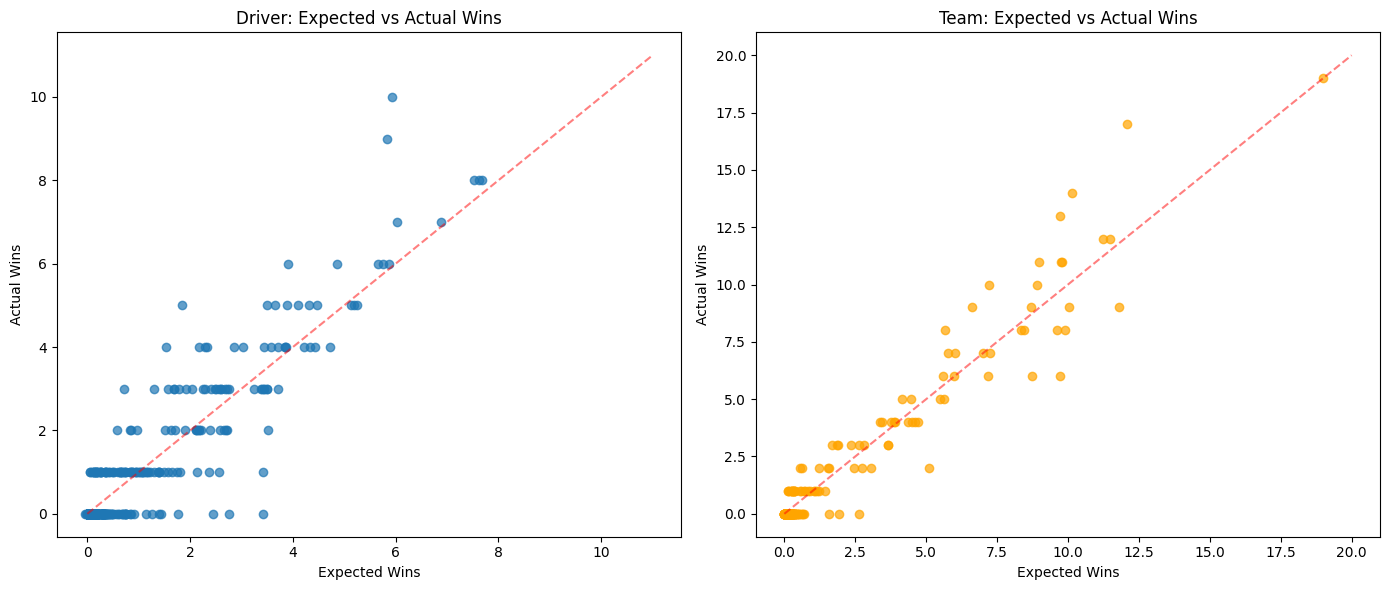

#####################################################################################################
#                                            POISSON                                              
#####################################################################################################

+-----------       Aggregated DRIVER Predictions: Expected Wins vs Actual Wins      -----------+


,race_season,driver_fullname,actual_wins,expected_wins,model_type,model_id,win_diff,performance_diff,over_under
0,2024,Kyle Larson,6,4.807418,poisson,poisson_20250312_1409,1.192582,1.192582,Over
1,2024,Joey Logano,4,0.642125,poisson,poisson_20250312_1409,3.357875,3.357875,Over
2,2024,Tyler Reddick,3,1.324589,poisson,poisson_20250312_1409,1.675411,1.675411,Over
3,2024,William Byron,3,1.420883,poisson,poisson_20250312_1409,1.579117,1.579117,Over
4,2024,Ryan Blaney,3,1.795360,poisson,poisson_20250312_1409,1.204640,1.204640,Over


+-----------       Aggregated TEAM Predictions: Expected Wins vs Actual Wins      -----------+


,race_season,team_name,actual_wins,expected_wins,model_type,model_id,win_diff,performance_diff,over_under
0,2024,Hendrick Motorsports,11,8.609256,poisson,poisson_20250312_1409,2.390744,2.390744,Over
1,2024,Team Penske,8,2.689860,poisson,poisson_20250312_1409,5.310140,5.310140,Over
2,2024,Joe Gibbs Racing,6,6.053513,poisson,poisson_20250312_1409,-0.053513,-0.053513,Under
3,2024,23XI Racing,3,1.949194,poisson,poisson_20250312_1409,1.050806,1.050806,Over
4,2024,Trackhouse Racing,2,1.156953,poisson,poisson_20250312_1409,0.843047,0.843047,Over


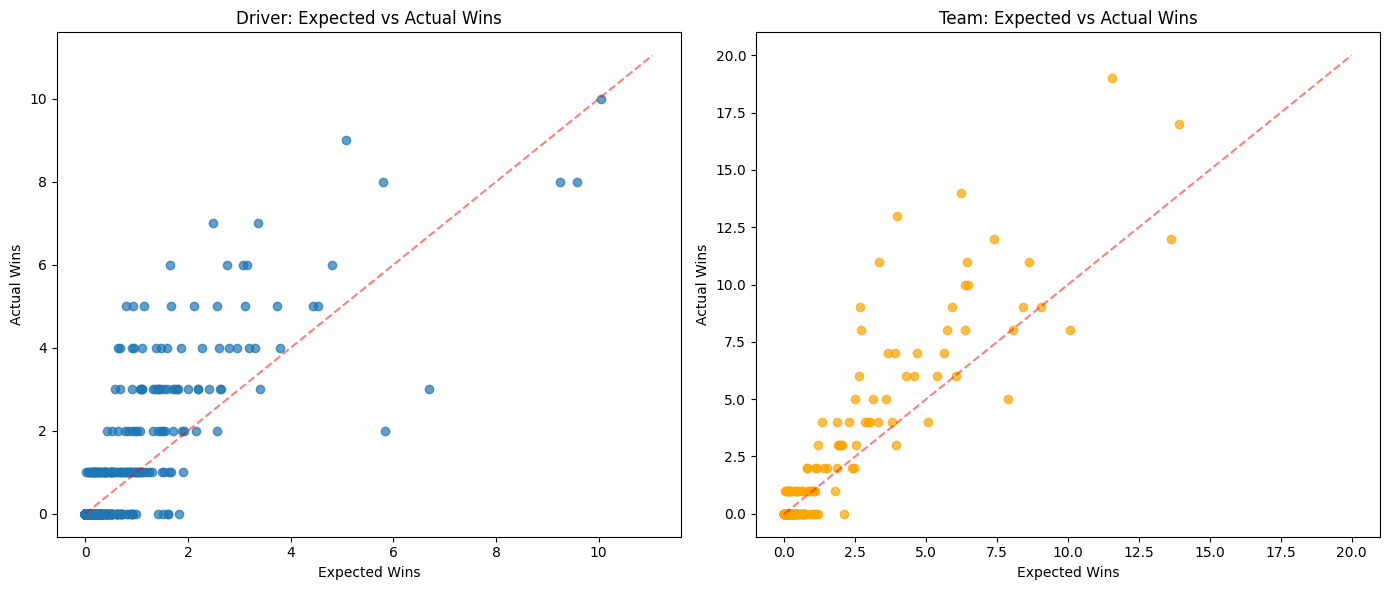

In [54]:
# poisson_20250312_1409
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def analysis_01(model_id):
        
    model_type = model_id.split('_')[0]
    print(f"#####################################################################################################\n#\
                                            {model_type.upper()}                                      \
        \n#####################################################################################################\n")
    # 1) Load driver-level over/under performance data 
    #    (assumes the file contains columns 'driver_fullname', 'actual_wins', 'expected_wins').
    analysis_path = os.path.join('models', f"{model_type}", f"{model_id}", 'analysis')
    driver_df = pd.read_csv(analysis_path + '/driver_over_under_performance.csv')
    print('+-----------       Aggregated DRIVER Predictions: Expected Wins vs Actual Wins      -----------+')
    display(driver_df.head())

    # 2) Load team-level over/under performance data
    #    (assumes the file contains columns 'team_name', 'actual_wins', 'expected_wins').
    team_df = pd.read_csv(analysis_path + '/team_over_under_performance.csv')
    print('+-----------       Aggregated TEAM Predictions: Expected Wins vs Actual Wins      -----------+')
    display(team_df.head())

    # 3) Create subplots: one for drivers, one for teams
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

    # === DRIVER PLOT ===
    axes[0].scatter(driver_df["expected_wins"], driver_df["actual_wins"], alpha=0.7)
    axes[0].set_title("Driver: Expected vs Actual Wins")
    axes[0].set_xlabel("Expected Wins")
    axes[0].set_ylabel("Actual Wins")

    # Optional: add reference line for perfect 1:1 match
    max_driver_val = max(driver_df["expected_wins"].max(), driver_df["actual_wins"].max()) + 1
    axes[0].plot([0, max_driver_val], [0, max_driver_val], linestyle="--", color="red", alpha=0.5)

    # === TEAM PLOT ===
    axes[1].scatter(team_df["expected_wins"], team_df["actual_wins"], alpha=0.7, color="orange")
    axes[1].set_title("Team: Expected vs Actual Wins")
    axes[1].set_xlabel("Expected Wins")
    axes[1].set_ylabel("Actual Wins")

    # Optional: add reference line for perfect 1:1 match
    max_team_val = max(team_df["expected_wins"].max(), team_df["actual_wins"].max()) + 1
    axes[1].plot([0, max_team_val], [0, max_team_val], linestyle="--", color="red", alpha=0.5)

    plt.tight_layout()
    plt.show()

# NOTE: The dashed red diagonal line indicates where expected_wins == actual_wins.
#    Points above this line had more actual wins than expected; points below had fewer.

model_id = 'poisson_20250312_1409'
# model_id = 'gbm_20250312_1740'

analysis_01('gbm_20250312_1740')
analysis_01('poisson_20250312_1409')

NOTE: While at first glance, the GBM model looks to be performing better, recall how overfit it is. The data you see above reflects predictions on the entire data set (which is quite the taboo from a modeling standpoint, but it serves to emphasize a point). IF you separate out this dataset into Train and Test rows, you would see a wide divergence in the GBM model compared with the Poisson.

Because the question at hand surrounded all drivers across all seasons, it logically made sense to apply predictions to everyone. In reality, you would partition out the out of sample data and evaluate only on that.

If we consider the fact that those drivers who had a positive `win_diff` rate were ***more likely*** to over perform, than the top 5 over-performing drivers, and consequently the bottom 5 under-performing drivers are as follows: 

In [64]:
# driver_df.groupby(['race_season', 'driver_fullname']).agg({'win_diff':'max'}).sort_values(by=['win_diff'], ascending = False)

# 1) Aggregate win_diff for each driver and season
df_agg = (
    driver_df
    .groupby(['race_season', 'driver_fullname'], as_index=False)
    .agg({
        'actual_wins': 'max',
        'expected_wins': 'max',
        'win_diff': 'max'
    })
)

# 2) Top 5 (largest) win_diff
top5 = df_agg.groupby('race_season', group_keys=False).apply(
    lambda x: x.nlargest(5, 'win_diff')
).reset_index(drop=True)

# 2) Bottom 5 (smallest) win_diff
bottom5 = df_agg.groupby('race_season', group_keys=False).apply(
    lambda x: x.nsmallest(5, 'win_diff')
).reset_index(drop=True)

print("TOP 5 (LARGEST) win_diff")
display(top5)

print("BOTTOM 5 (SMALLEST) win_diff")
display(bottom5)

TOP 5 (LARGEST) win_diff


C:\Users\jschw\AppData\Local\Temp\ipykernel_22732\2483940831.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = df_agg.groupby('race_season', group_keys=False).apply(
C:\Users\jschw\AppData\Local\Temp\ipykernel_22732\2483940831.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bottom5 = df_agg.groupby('race_season', group_keys=False).apply(


,race_season,driver_fullname,actual_wins,expected_wins,win_diff
0,2014,Dale Earnhardt Jr,4,1.533167,2.466833
1,2014,Brad Keselowski,6,4.850257,1.149743
2,2014,Joey Logano,5,3.892114,1.107886
3,2014,Carl Edwards,2,0.963461,1.036539
4,2014,AJ Allmendinger,1,0.112924,0.887076
5,2015,Jimmie Johnson,5,3.492328,1.507672
6,2015,Kyle Busch,5,3.660491,1.339509
7,2015,Carl Edwards,2,0.836767,1.163233
8,2015,Matt Kenseth,5,4.090813,0.909187
9,2015,Dale Earnhardt Jr,3,2.256184,0.743816


BOTTOM 5 (SMALLEST) win_diff


,race_season,driver_fullname,actual_wins,expected_wins,win_diff
0,2014,Matt Kenseth,0,0.901313,-0.901313
1,2014,Kyle Larson,0,0.842189,-0.842189
2,2014,Jamie McMurray,0,0.743272,-0.743272
3,2014,Ryan Newman,0,0.373620,-0.373620
4,2014,Justin Allgaier,0,0.295892,-0.295892
5,2015,Kevin Harvick,3,3.380721,-0.380721
6,2015,Brad Keselowski,1,1.379514,-0.379514
7,2015,Ryan Newman,0,0.363797,-0.363797
8,2015,Jamie McMurray,0,0.329831,-0.329831
9,2015,Martin Truex Jr,1,1.222432,-0.222432


#### QUESTION #3: HOW OFTEN DOES THE FAVORITE WIN THE CHAMPIONSHIP?

In [66]:
model_id = 'gbm_20250312_1740'
model_id = 'poisson_20250312_1409'
model_type = model_id.split('_')[0]

analysis_path = os.path.join('models', f"{model_type}", f"{model_id}", 'analysis')
driver_champs = pd.read_csv(analysis_path + '/driver_championship_comparison.csv')
team_champs = pd.read_csv(analysis_path + '/team_championship_comparison.csv')

display(driver_champs)
display(team_champs)

,race_season,expected_champion_driver,expected_wins,actual_champion,match
0,2014,Kevin Harvick,2.122343,Kevin Harvick,True
1,2015,Kevin Harvick,6.685595,Kyle Busch,False
2,2016,Kevin Harvick,3.312668,Jimmie Johnson,False
3,2017,Martin Truex Jr,9.247981,Martin Truex Jr,True
4,2018,Kevin Harvick,9.578779,Joey Logano,False
5,2019,Kyle Busch,4.436790,Kyle Busch,True
6,2020,Kevin Harvick,5.081069,Chase Elliott,False
7,2021,Kyle Larson,10.048897,Kyle Larson,True
8,2022,Chase Elliott,3.103078,Joey Logano,False
9,2023,William Byron,2.763713,Ryan Blaney,False


,race_season,expected_champion_team,expected_wins,actual_champion_team,match
0,2014,Hendrick Motorsports,3.975886,Stewart-Haas Racing,False
1,2015,Stewart-Haas Racing,7.892592,Joe Gibbs Racing,False
2,2016,Joe Gibbs Racing,7.389707,Hendrick Motorsports,False
3,2017,Furniture Row Racing,10.081744,Furniture Row Racing,True
4,2018,Stewart-Haas Racing,13.627681,Team Penske,False
5,2019,Joe Gibbs Racing,11.568923,Joe Gibbs Racing,True
6,2020,Stewart-Haas Racing,6.459037,Hendrick Motorsports,False
7,2021,Hendrick Motorsports,13.913751,Hendrick Motorsports,True
8,2022,Hendrick Motorsports,6.451099,Team Penske,False
9,2023,Joe Gibbs Racing,6.381811,Team Penske,False


As shown above, the favorite according to expected wins per season has historically won at a rate of: [4/11 (drivers) - 36.4%] and [3/11 (teams) - 27.3%] according to the chosen Poisson model. All things considered, a rough 1 out of 3 success rate is pretty good in my estimation - just don't bet your mortgage!

In [ ]:
# Actuals according to: https://www.racing-reference.info/nascar-cup-series-stats/
champs_actual = pd.read_csv('data/champions_2014_2024.csv')
champs_actual

,race_season,actual_champion,actual_champion_wins,race_season.1,actual_champion_team,actual_champion_team_wins
0,2014,Kevin Harvick,5,2014,Stewart-Haas Racing,6
1,2015,Kyle Busch,5,2015,Joe Gibbs Racing,14
2,2016,Jimmie Johnson,5,2016,Hendrick Motorsports,5
3,2017,Martin Truex Jr,8,2017,Furniture Row Racing,8
4,2018,Joey Logano,3,2018,Team Penske,3
5,2019,Kyle Busch,5,2019,Joe Gibbs Racing,19
6,2020,Chase Elliott,5,2020,Hendrick Motorsports,7
7,2021,Kyle Larson,10,2021,Hendrick Motorsports,17
8,2022,Joey Logano,4,2022,Team Penske,4
9,2023,Ryan Blaney,3,2023,Team Penske,3


## Additional Questions for Further Analysis

1. **Performance Transfer:** Does a driver who switches teams mid-career
   maintain their historical performance level, or is there a synergy
   effect (positive or negative) that emerges after joining a new team?

2. **Shared Knowledge Impact:** How much do teammates’ performances
   influence each other? For instance, does having a high-performing
   teammate raise the performance ceiling for others on the same team?

3. **Resource Allocation Patterns:** How does a team distribute resources
   among drivers (like engineering focus, pit crew priorities, etc.)?
   Do drivers on larger teams with more resources inherently
   gain an edge, or does one star driver monopolize resources at the
   expense of others?

4. **Driver Development Trajectories:** Are certain teams better at
   onboarding rookie drivers (e.g., teaching best practices,
   refining driving style, or providing mental coaching)? Can we
   detect consistent, season-over-season growth patterns for
   newcomers within specific teams?

5. **Driver-Specific Engineering Adjustments:** Do drivers known for
   aggressive styles benefit more from particular teams' engineering
   approaches than more conservative drivers? Conversely, how do
   teams adapt to maximize each driver's style?

## Future Directions

### 1. Driver Physiology & Metadata
- **Potential Data Sources**  
  - Onboard telemetry capturing driver heart rate, breathing rate, etc.  
  - Fitness device logs (e.g., Fitbit, Oura Ring, etc)  
  - Personal training regimens tracked over time  
- **Hypotheses**  
  - Drivers with higher baseline fitness recover from race fatigue quicker and maintain consistent performance.  
  - Physical exhaustion or dehydration disproportionately affects lead-lap performance.  
- **Applicable Statistics / ML / AI Methodology**  
  - Longitudinal analysis (tracking a driver’s physical metrics through the season).  
  - Time series forecasting / Functional Data Analysis (predicting exertion levels race-to-race).  
  - Mixed-effects models (accounting for variations between different drivers and seasons).

### 2. Weather & Track Conditions
- **Potential Data Sources**  
  - Historical meteorological data (temperature, rainfall, humidity).  
  - Surface composition records (asphalt condition, track banking details).  
  - Post-race track condition notes (e.g., track dryness or rubber buildup).  
- **Hypotheses**  
  - Certain drivers excel under adverse weather or track conditions; others drop off.  
  - Track surface composition combined with weather might be an overlooked factor in driver performance.  
- **Applicable Statistics / ML / AI Methodology**  
  - Interaction terms in regression (weather × driver style).  
  - Bayesian hierarchical modeling (to handle uncertain meteorological data).  
  - Spatio-temporal analysis (if track segment-level data becomes available).

### 3. Team Resource & Funding Details
- **Potential Data Sources**  
  - Public sponsorship announcements, annual reports, or known budgets.  
  - Pit-crew staffing numbers, average pit-stop times.  
  - Facilities & R&D investments (wind-tunnel usage, simulator hours).  
- **Hypotheses**  
  - Teams with higher budgets systematically outperform in resource-intensive areas (car setup, pit stops).  
  - Resource constraints are more visible on longer races or demanding tracks.  
- **Applicable Statistics / ML / AI Methodology**  
  - Causal inference (difference-in-differences if a team’s funding changes drastically).  
  - Multivariate regression modeling linking budgets, pit-crew data, and final standings.  
  - Random forest or gradient boosting to detect which funding factors correlate most strongly with wins.

### 4. Live Predictive Analytics
- **Potential Data Sources**  
  - In-race telemetry (lap times, speed, fuel usage).  
  - Real-time weather feeds.  
  - Pit-stop updates and race incidents (wrecks, caution flags).  
- **Hypotheses**  
  - Immediate feedback loops about tire wear and positioning can drastically improve in-race decision making (e.g., pit-stop timing).  
  - Dynamic track conditions (temp changes, rubber accumulation) affect short-run vs. long-run performance differently.  
- **Applicable Statistics / ML / AI Methodology**  
  - Online or incremental learning algorithms (constantly update predictions as new data flows in).  
  - Real-time anomaly detection (sudden mechanical issues).  
  - Reinforcement learning or decision support systems for pit-stop strategies.

### 5. Longitudinal Driver Development
- **Potential Data Sources**  
  - Multi-season driver stats, training logs, engineering feedback.  
  - Career records for rookies transitioning across multiple teams.  
  - Mentoring program details, if available.  
- **Hypotheses**  
  - Certain teams have specialized programs leading to faster rookie improvement.  
  - Drivers plateau or regress after a specific number of seasons unless they switch teams or get fresh engineering input.  
- **Applicable Statistics / ML / AI Methodology**  
  - Growth curve modeling (assessing performance gains over multiple seasons).  
  - Mixed-effects models (driver-level random effects to capture individual learning rates).  
  - Survival analysis (time until first win or time until performance peaks).

### 6. Generative AI / Large Language Models (LLMs)
- **Potential Data Sources**  
  - Open source models from Hugging Face (Llama, Gemini, etc.)  
  - Twitter data feeds, in-race call audio between driver and crew chief
- **Hypotheses**  
  - Training playbooks that can be validated by pit crews and drivers to aid with strategy
- **Applicable Statistics / ML / AI Methodology**  
  - Prompt Engineering (Zero-Shot, One-Shot, Few-Shot)
  - Ensembling embeddings from LLMs into traditional ML (i.e. XGBoost) for more explainability 
  - Fine-Tuning and/or RAG pipelines for domain-specific (team-specific) information retrieval

### 7. Interactive Dashboards
- **Potential Data Sources**  
  - Existing pipeline outputs (predictions, over/under performance, champion comparisons).  
  - Additional real-time data feeds (if live analytics are implemented).  
- **Hypotheses**  
  - A user-friendly interface enables more stakeholders (team managers, strategy staff) to explore performance insights directly, revealing new correlations.  
  - Dashboard usage logs can highlight which metrics decision makers value most.  
- **Applicable Statistics / ML / AI Methodology**  
  - Data visualization techniques (Plotly Dash, Streamlit) for interactive filtering and scenario testing.  
  - Predictive scenarios or simulation-based “what-if” analysis (Monte Carlo or custom simulation logic).  
  - Graph analytics (if networks of driver-team relationships are shown in real time).
